In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Disaster_tweet/train.csv")

In [ ]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
df.text[7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

In [ ]:
import re
for i in range(len(df)):
  df.iloc[i].text=re.sub(r'^https?:\/\/.*[\r\n]*', '', df.iloc[i].text, flags=re.MULTILINE)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [ ]:
for i in range(len(df)):
  if not type(df.iloc[i].target) == np.int64:
    df.drop(i,inplace=True)

In [ ]:
df.target.unique()


array([1, 0])

#### **Verifying the availability of cuda**

In [ ]:
device_name=tf.test.gpu_device_name()
if device_name=='/device:GPU:0':
  print("Working on GPU")
else:
  print("GPU not found")

Working on GPU


#### **Setting The Device On CUDA**

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use the GPU : ", torch.cuda.get_device_name(0))
else:
  print("NO GPU available , using CPU instead.")
  device= torch.device("CPU")

There are 1 GPU(s) available.
We will use the GPU :  Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 36.8 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 45.8 MB/s 
     |████████████████████████████████| 3.3 MB 49.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### **Exploratory Data Analysis on Dataset**

In [ ]:
print("The Number of Sentences in the Train Dataset: ", len(df))

The Number of Sentences in the Train Dataset:  7613


In [ ]:
disaster=df.target.sum()
percent = disaster/len(df)*100
print("The total percentage of Disaster Tweets in the Dataset are : ",percent ,"%" )

The total percentage of Disaster Tweets in the Dataset are :  42.96597924602653 %


In [ ]:
non_disaster=len(df)-disaster
non_disaster

4342

In [ ]:
dic={"Disaster":disaster,"Non-Disaster":non_disaster}
dic

{'Disaster': 3271, 'Non-Disaster': 4342}

#### **Visualisation Of The Dataset**

Text(0.5, 0, 'Disaster Status')

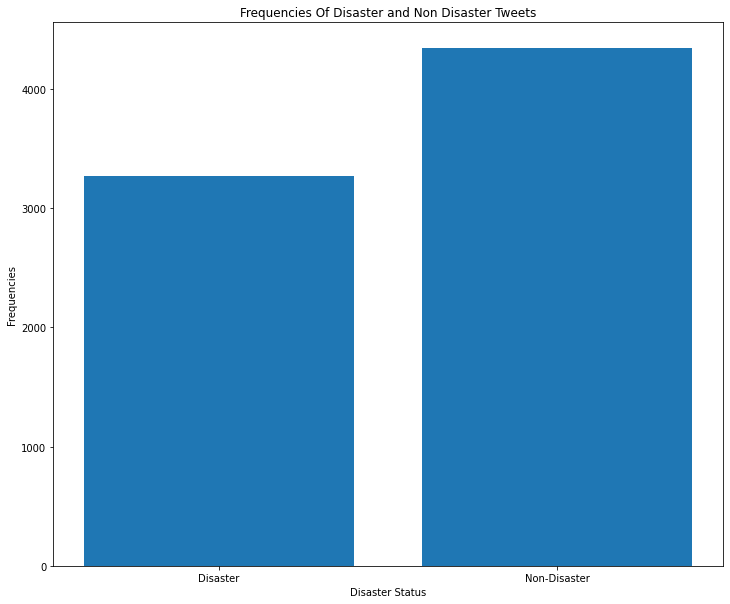

In [ ]:
plt.figure(figsize=(12,10))
plt.bar(range(len(dic)), list(dic.values()), align='center')
plt.title("Frequencies Of Disaster and Non Disaster Tweets")
plt.xticks(range(len(dic)), list(dic.keys()))
plt.ylabel("Frequencies")
plt.xlabel("Disaster Status")

## **Tokenisation and Input Formatting**

In [ ]:
from transformers import BertTokenizer
print("Initiating.................")
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

Initiating.................


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tweets=df.text.values
labels=df.target.values

In [ ]:
tweets

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [ ]:
labels

array([1, 1, 1, ..., 1, 1, 1])

### **Tokenisation and Formatting**

In [ ]:
max_len=0
for tweet in tweets:
  input_ids=tokenizer.encode(tweet,add_special_tokens=True)
  max_len=max(max_len,len(input_ids))
print("Max Tweet Length:",max_len)

Max Tweet Length: 84


In [ ]:
input_ids

[101,
 1996,
 6745,
 1024,
 2062,
 5014,
 10958,
 5422,
 2011,
 2642,
 2662,
 3748,
 10273,
 1011,
 5925,
 2739,
 8299,
 1024,
 1013,
 1013,
 1056,
 1012,
 2522,
 1013,
 1061,
 8029,
 2549,
 27472,
 4160,
 29097,
 102]

In [ ]:
input_ids=[]
attention_masks=[]
for tweet in tweets:
  encoded_dict=tokenizer.encode_plus(
      tweet,
      add_special_tokens = True,
      max_length=100,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors="pt"
  )
  input_ids.append(encoded_dict["input_ids"])
  attention_masks.append(encoded_dict["attention_mask"])
input_ids=torch.cat(input_ids,dim=0)
attention_masks=torch.cat(attention_masks,dim=0)
labels=torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print("Original:",tweets[0])
print("Token_Ids:",input_ids[0])

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token_Ids: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


### **Training and Validation Split**

In [ ]:
from torch.utils.data import TensorDataset ,random_split

In [ ]:
dataset=TensorDataset(input_ids,attention_masks,labels)
dataset

In [ ]:
train_size=int(0.75*len(dataset))
val_size=len(dataset)-train_size

In [ ]:
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

In [ ]:
print("The train size is:",train_size)
print("The validation size is:",val_size)

The train size is: 5709
The validation size is: 1904


### **Data Loader**

In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

In [ ]:
batch_size=32
train_dataloader=DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

In [ ]:
validation_dataloader=DataLoader(val_dataset,
                                 sampler=SequentialSampler(val_dataset),
                                 batch_size=batch_size)

### **Training**

In [ ]:
from transformers import BertForSequenceClassification , AdamW , BertConfig

### **Model Architecture**

In [ ]:
model=BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2,output_attentions=False,output_hidden_states=False)
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params=list(model.named_parameters())
print("The total number of named parametres are:",len(params))
print("============== Embedding Layer==================== \n")
for p in params[0:3]:
  print(p[0],str(tuple(p[1].size())))
print("============== Norm Layer==================== \n")
for f in params[3:5]:
  print(f[0],str(tuple(f[1].size())))
print("============== First Transformer Layer==================== \n")
for p in params[5:21]:
  print(p[0],str(tuple(p[1].size())))
print("============== Output Layer==================== \n")
for p in params[197:201]:
  print(p[0],str(tuple(p[1].size())))

The total number of named parametres are: 201
============== Embedding Layer==================== 

bert.embeddings.word_embeddings.weight (30522, 768)
bert.embeddings.position_embeddings.weight (512, 768)
bert.embeddings.token_type_embeddings.weight (2, 768)
============== Norm Layer==================== 

bert.embeddings.LayerNorm.weight (768,)
bert.embeddings.LayerNorm.bias (768,)
============== First Transformer Layer==================== 

bert.encoder.layer.0.attention.self.query.weight (768, 768)
bert.encoder.layer.0.attention.self.query.bias (768,)
bert.encoder.layer.0.attention.self.key.weight (768, 768)
bert.encoder.layer.0.attention.self.key.bias (768,)
bert.encoder.layer.0.attention.self.value.weight (768, 768)
bert.encoder.layer.0.attention.self.value.bias (768,)
bert.encoder.layer.0.attention.output.dense.weight (768, 768)
bert.encoder.layer.0.attention.output.dense.bias (768,)
bert.encoder.layer.0.attention.output.LayerNorm.weight (768,)
bert.encoder.layer.0.attention.outpu

### **Optimizer**

In [ ]:
import torch.optim as optim 

#### **Stochastic Gradient Descent**

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### **Adam**

In [ ]:
#optimizer = AdamW(model.parameters(),lr =2e-5,eps=1e-8)

#### **Learning Rate Scheduler**

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs=10
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= total_steps)

In [ ]:
from transformers import get_polynomial_decay_schedule_with_warmup
epochs=10
total_steps = len(train_dataloader)*epochs+100
scheduler2 = get_polynomial_decay_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= total_steps)

### **Training Loop**

**Helper Function**

**F1 Accuracy**

In [ ]:
import numpy as np
def flat_accuracy(preds,labels):
  pred_flat=np.argmax(preds,axis=1).flatten()
  labels_flat=labels.flatten()
  return np.sum(pred_flat==labels_flat)/len(labels_flat)

**Time Elapsed**

In [ ]:
import time
import datetime

In [ ]:
def format_time(elapsed):
  elapsed_time=int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_time))

In [ ]:
import random

In [ ]:
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values=[]

for epoch in range(0,epochs):
  #=========================================#
  #                Training                 #                      
  #=========================================#

  print("===================================== \n")
  print("The Epoch Number is :",epoch+1)
  print("Training........")


  t0=time.time()

  total_loss=0

  model.train()seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values=[]

for epoch in range(0,epochs):
  #=========================================#
…  total_loss=0

  model.train()
  for step,batch in enumerate(train_dataloader):
    if step %40==0 and not step==0:
      elapsed =format_time(time.time()-t0)
      print("========================================================= \n")
      print("The Current Step is :",step)
      print("The Current Trainloader is :",len(train_dataloader))
      print("The Elapsed Time is :",elapsed)
      print("========================================================= \n")
    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_labels = batch[2].to(device) 

    model.zero_grad()

    outputs = model(b_input_ids,token_type_ids=None,attention_mask=b_input_masks,labels=b_labels)

    loss=outputs[0]

    total_loss+= loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
    optimizer.step()
    scheduler2.step()
  avg_train_loss=total_loss/len(train_dataloader)
  loss_values.append(avg_train_loss)

  print("")
  print("Average training Loss : ", avg_train_loss)
  print(" Training epoch took : ",format_time(time.time()-t0)) 
  #=========================================#
  #                Validation               #                      
  #=========================================#
  print("")
  print("Running Validation ........ ")
  t0= time.time()
  total_loss=0
  model.eval()seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values=[]

for epoch in range(0,epochs):
  #=========================================#
  #                Training                 #                      
  #=========================================#

  print("===================================== \n")
  print("The Epoch Number is :",epoch+1)
  print("Training........")
  eval_loss, eval_accuracy = 0 , 0
  nb_eval_steps , nb_eval_examples = 0 , 0
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids , b_input_masks , b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None , attention_mask = b_input_masks)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    labels_ids= b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits , labels_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps +=1
  print("Accuracy :", eval_accuracy/nb_eval_steps)
  print("Validation Time : ", format_time(time.time()-t0))
print("")
print("Training Complete.........!!!!!!!!!!!!")


The Epoch Number is : 1
Training........


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



The Current Step is : 40
The Current Trainloader is : 179
The Elapsed Time is : 0:00:40


The Current Step is : 80
The Current Trainloader is : 179
The Elapsed Time is : 0:01:20


The Current Step is : 120
The Current Trainloader is : 179
The Elapsed Time is : 0:02:00


The Current Step is : 160
The Current Trainloader is : 179
The Elapsed Time is : 0:02:40


Average training Loss :  0.37905389919627314
 Training epoch took :  0:02:58

Running Validation ........ 
Accuracy : 0.81875
Validation Time :  0:00:22

The Epoch Number is : 2
Training........

The Current Step is : 40
The Current Trainloader is : 179
The Elapsed Time is : 0:00:40


The Current Step is : 80
The Current Trainloader is : 179
The Elapsed Time is : 0:01:19


The Current Step is : 120
The Current Trainloader is : 179
The Elapsed Time is : 0:01:59


The Current Step is : 160
The Current Trainloader is : 179
The Elapsed Time is : 0:02:39


Average training Loss :  0.3639196775146037
 Training epoch took :  0:02:57

Ru

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Loss')

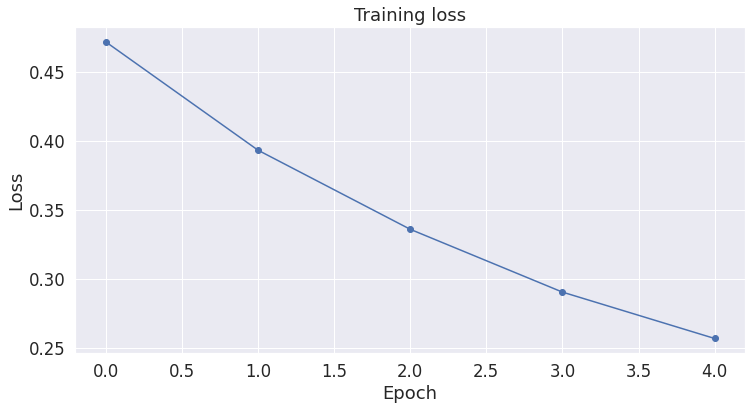

In [ ]:
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"]=(12,6)
plt.plot(loss_values,"b-o")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

## **Test Database**

#### **Loading The Test Database**

In [ ]:
df_test=pd.read_csv("/content/drive/MyDrive/Disaster_tweet/test.csv")

In [ ]:
print("The Number of Tweets to classify are: ", df_test.shape[0])

The Number of Tweets to classify are:  3263


In [ ]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


**Tokenisation Of The Test Database**

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Disaster_tweet/test.csv")

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

tweets = df.text.values
#labels = df.label.values

input_ids = []

for tweet in tweets:
    encoded_tweet = tokenizer.encode(
                        tweet,                      
                        add_special_tokens = True, 
                   )
    
    input_ids.append(encoded_tweet)

input_ids = pad_sequences(input_ids, maxlen=100, 
                          dtype="long", truncating="post", padding="post")


attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
#prediction_labels = torch.tensor(labels)


batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 3,263



In [ ]:
print("Initiating Testing.......")
model.eval()
predictions=[]
for batch in prediction_dataloader:
  batch=tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  #true_labels.append(label_ids)
print("Done...........!!!!!!!!!!")

Initiating Testing.......
Done...........!!!!!!!!!!


In [ ]:
predictions

## **Predictions**

In [ ]:
preds=[]
for i in predictions:
  for j in range(len(i)):
    preds.append(np.argmax(i[j]))
print(preds)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
test_disaster=sum(preds)
test_percent=test_disaster/len(preds)*100
print("The total composition of Disaster Tweets in Test Dataset :", test_percent,"%")

The total composition of Disaster Tweets in Test Dataset : 41.955255899479006 %


In [ ]:
submission=pd.DataFrame({"id":df_test.id,"target":preds})

### **Saving The Model**

In [ ]:
#torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
#files.download('checkpoint.pth')

In [ ]:
pwd

'/content'

In [ ]:
submission.to_csv("/content/drive/MyDrive/Disaster_tweet/SubmissionTextroid.csv",index=None)